In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import GLM, families
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

#### Load the data, check for missing values, and prepare it for analysis.

In [3]:
housing_df = pd.read_csv('housing.csv')
housing_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Drop ID column
housing_df = housing_df.drop(columns=['Id'])

# Drop columns with more than 30% missing values
threshold_missing = 0.3 * housing_df.shape[0]
housing_df = housing_df.dropna(axis=1, thresh=threshold_missing)

# Fill missing values
for col in housing_df.columns:
    if housing_df[col].dtype == 'object':  # For categorical variables
        housing_df[col].fillna(housing_df[col].mode()[0], inplace=True)
    else:  # For numeric variables
        housing_df[col].fillna(housing_df[col].mean(), inplace=True)

# Encode categorical variables
house_encoded = pd.get_dummies(housing_df, drop_first=True)

# Split predictors and target variable
target = 'SalePrice'
X = house_encoded.drop(columns=[target])
y = house_encoded[target]


C:\Users\ROG\AppData\Local\Temp\ipykernel_18836\2226517459.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_df[col].fillna(housing_df[col].mean(), inplace=True)
C:\Users\ROG\AppData\Local\Temp\ipykernel_18836\2226517459.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [6]:
# Correlation analysis to select top predictors
numeric_cols = house_encoded.select_dtypes(include=[np.number]).columns
correlation = house_encoded[numeric_cols].corr()['SalePrice'].abs().sort_values(ascending=False)

# Select top 15 correlated predictors
top_predictors = correlation.index[1:16]  # Excluding SalePrice
X_reduced = X[top_predictors]

# Function to calculate VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif.sort_values(by="VIF", ascending=False)

# Calculate VIF for reduced predictors
vif = calculate_vif(X_reduced)
print("VIF values:\n", vif)


VIF values:
         Variable           VIF
11   GarageYrBlt  19184.956461
8      YearBuilt  14671.241091
9   YearRemodAdd  12031.266002
7   TotRmsAbvGrd     58.808681
0    OverallQual     50.720295
1      GrLivArea     50.275946
5       1stFlrSF     38.285821
2     GarageCars     35.482093
3     GarageArea     31.342452
4    TotalBsmtSF     26.368382
6       FullBath     18.679167
14   LotFrontage     14.510240
13    BsmtFinSF1      2.960113
12    Fireplaces      2.733623
10    MasVnrArea      1.797308


#### Initial Correlation Analysis
* Identify predictors most correlated with the target variable.


Top features correlated with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


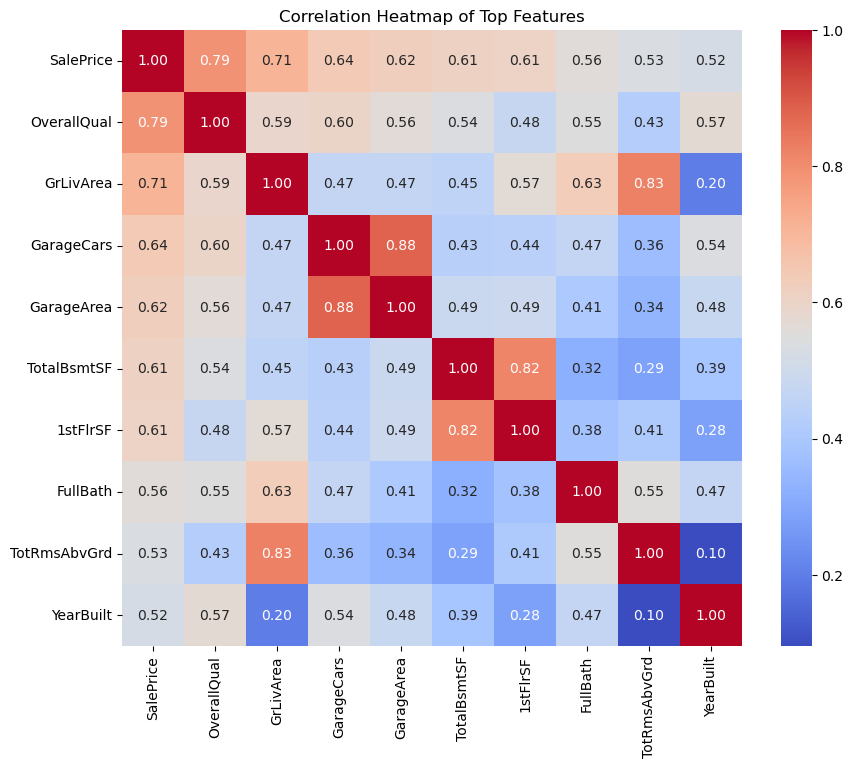

In [7]:
# Correlation matrix for numerical features
house_df = house_encoded.select_dtypes(include=[np.number])
correlation_matrix = house_df.corr()

# Correlation with SalePrice
correlation_with_target = correlation_matrix['SalePrice'].sort_values(ascending=False)
print("\nTop features correlated with SalePrice:")
print(correlation_with_target.head(10))

# Visualize top correlations
top_features = correlation_with_target.index[:10]
plt.figure(figsize=(10, 8))
sns.heatmap(house_df[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top Features')
plt.show()


#### Reducing Predictors Using VIF and Backward Elimination

In [8]:
# Backward elimination to reduce predictors based on VIF
def backward_elimination(X, threshold=5.0):
    while True:
        vif = calculate_vif(X)
        max_vif = vif['VIF'].max()
        if max_vif > threshold:
            drop_col = vif.loc[vif['VIF'] == max_vif, 'Variable'].values[0]
            print(f"Dropping '{drop_col}' with VIF: {max_vif}")
            X = X.drop(columns=[drop_col])
        else:
            break
    return X

# Perform backward elimination
X_selected = backward_elimination(X_reduced)
print("Final selected predictors:\n", X_selected.columns)


Dropping 'GarageYrBlt' with VIF: 19184.956461331156
Dropping 'YearBuilt' with VIF: 8499.959527265057
Dropping 'TotRmsAbvGrd' with VIF: 58.65518499133035
Dropping 'OverallQual' with VIF: 49.52843479507029
Dropping '1stFlrSF' with VIF: 37.181302937388324
Dropping 'GarageCars' with VIF: 32.9323719966106
Dropping 'GrLivArea' with VIF: 21.87495978473979
Dropping 'YearRemodAdd' with VIF: 18.44505960541273
Dropping 'TotalBsmtSF' with VIF: 12.253608953168962
Dropping 'FullBath' with VIF: 8.550348313818688
Dropping 'GarageArea' with VIF: 6.806209693929128
Final selected predictors:
 Index(['MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage'], dtype='object')


#### Building Generalized Linear Models (GLM)
Fit multiple GLM models with different predictor sets.

In [26]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Function to build and evaluate GLM models (reuse previous function)
def evaluate_glm(X_train, y_train, X_test, y_test):
    X_train_const = sm.add_constant(X_train)  # Add constant for intercept
    X_test_const = sm.add_constant(X_test)

    # Fit the GLM model
    model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian()).fit()

    # Predict on test set
    y_pred = model.predict(X_test_const)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    aic = model.aic

    print(model.summary())

    print("Model Performance:")
    print(f"R²: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"AIC: {aic:.2f}")
    return model, mse, r2, aic


# Compare multiple models with different predictor sets
results = []

# Model 1: Top 15 Correlated Predictors
X1 = X[top_predictors]  # Top predictors based on correlation
X_train1, X_test1, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
model1, mse1, r21, aic1 = evaluate_glm(X_train1, y_train, X_test1, y_test)
results.append(("Top 15 Correlated", mse1, r21, aic1))

# Model 2: Backward Elimination Predictors (Reduced VIF set)
X2 = X_selected  # Reduced predictors from backward elimination
X_train2, X_test2, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
model2, mse2, r22, aic2 = evaluate_glm(X_train2, y_train, X_test2, y_test)
results.append(("Backward Elimination", mse2, r22, aic2))

# Model 3: Smaller Subset - Top 8 Predictors
top_8_predictors = top_predictors[:8]  # Select a smaller subset of top predictors
X3 = X[top_8_predictors]
X_train3, X_test3, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)
model3, mse3, r23, aic3 = evaluate_glm(X_train3, y_train, X_test3, y_test)
results.append(("Top 8 Predictors", mse3, r23, aic3))

# Compare model results
results_df = pd.DataFrame(results, columns=["Model", "MSE", "R²", "AIC"])
print("\nModel Comparison:")
print(results_df)



                 Generalized Linear Model Regression Results                  
Dep. Variable:              SalePrice   No. Observations:                 1168
Model:                            GLM   Df Residuals:                     1152
Model Family:                Gaussian   Df Model:                           15
Link Function:               Identity   Scale:                      1.3270e+09
Method:                          IRLS   Log-Likelihood:                -13917.
Date:                Tue, 17 Dec 2024   Deviance:                   1.5287e+12
Time:                        16:01:13   Pearson chi2:                 1.53e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9701
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.27e+06   1.45e+05     -8.755   

In [10]:
# Function to visualize model performance
def evaluate_model_visuals(model, X_train, y_train, X_test, y_test, model_name):
    # Add constant for intercept
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # Get predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Residuals
    residuals = y_test - y_test_pred

    # Box Plot for Residuals
    plt.figure(figsize=(12, 6))
    sns.boxplot(residuals)
    plt.title(f"Box Plot of Residuals - {model_name}")
    plt.show()

    # Residuals vs Fitted (Predicted) Values
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Predicted Values - {model_name}")
    plt.show()

    # Actual vs Predicted Scatter Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot(y_test, y_test, color='red', linestyle='--')  # Perfect line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted Values - {model_name}")
    plt.show()

    print(f"Finished visual evaluation for {model_name}\n")


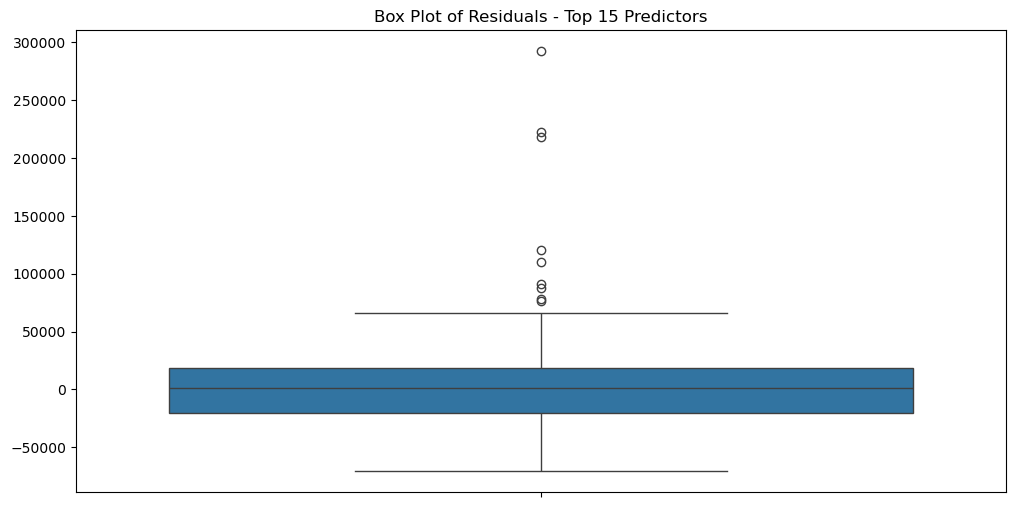

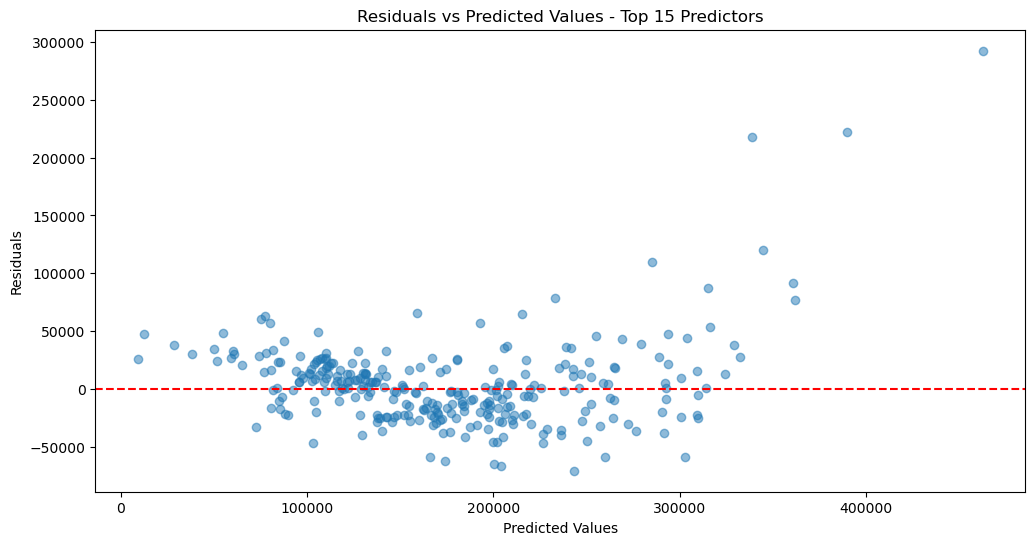

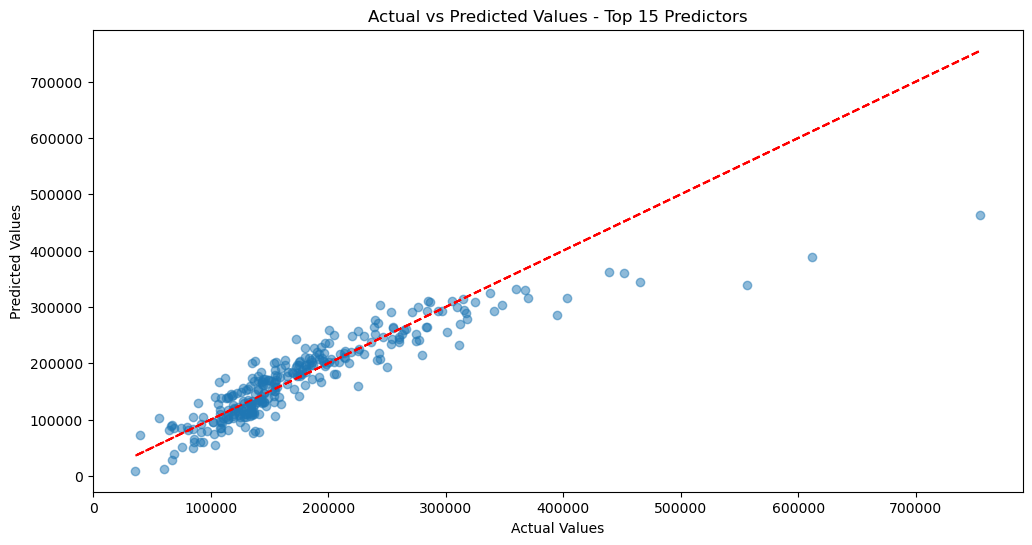

Finished visual evaluation for Top 15 Predictors



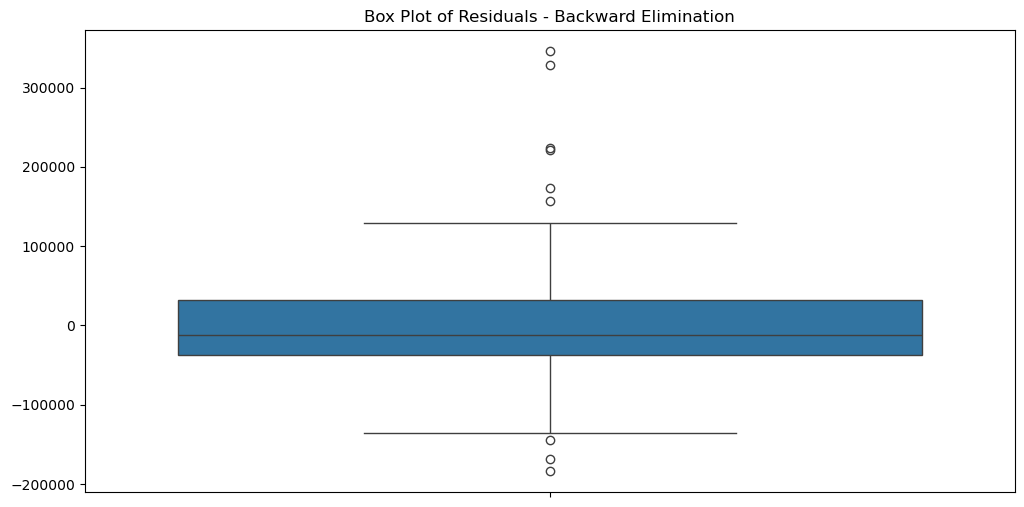

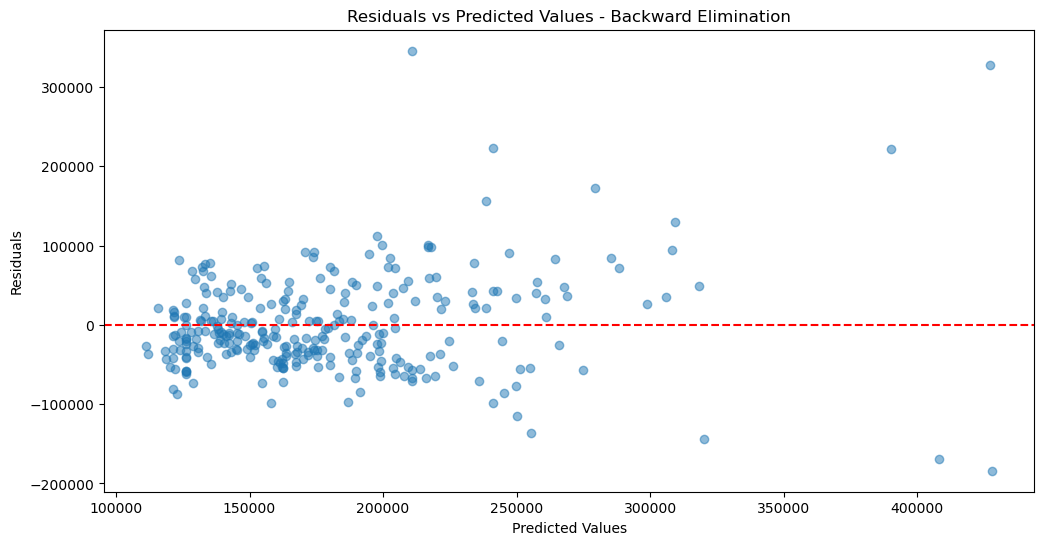

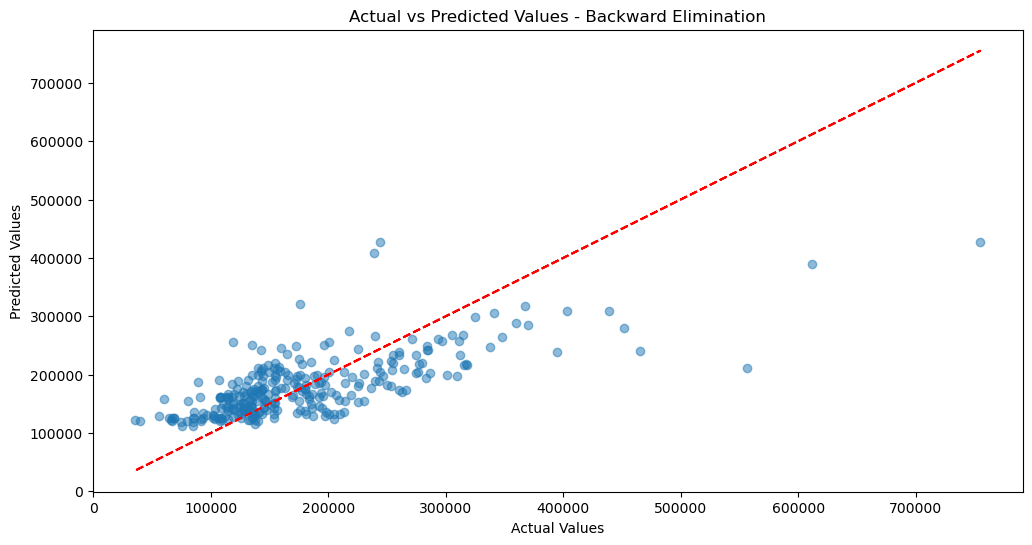

Finished visual evaluation for Backward Elimination



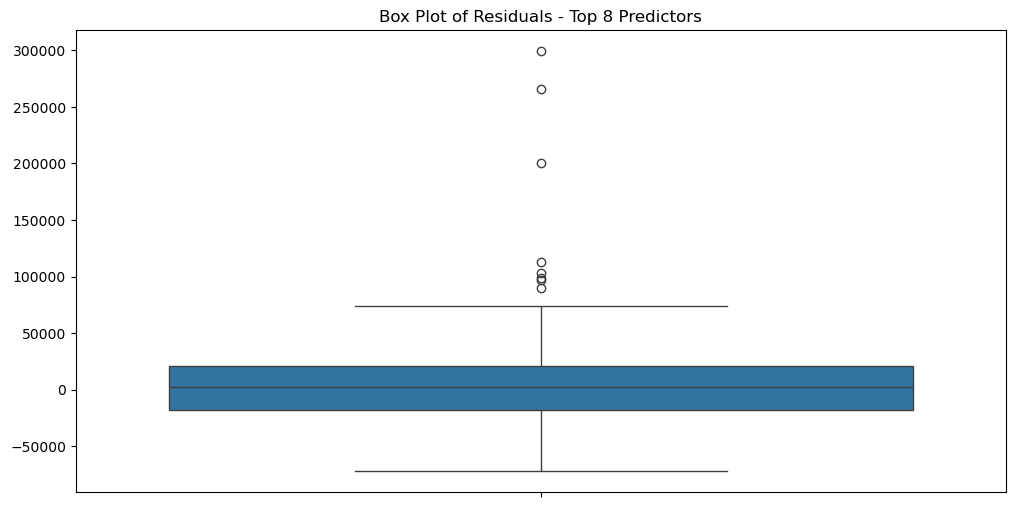

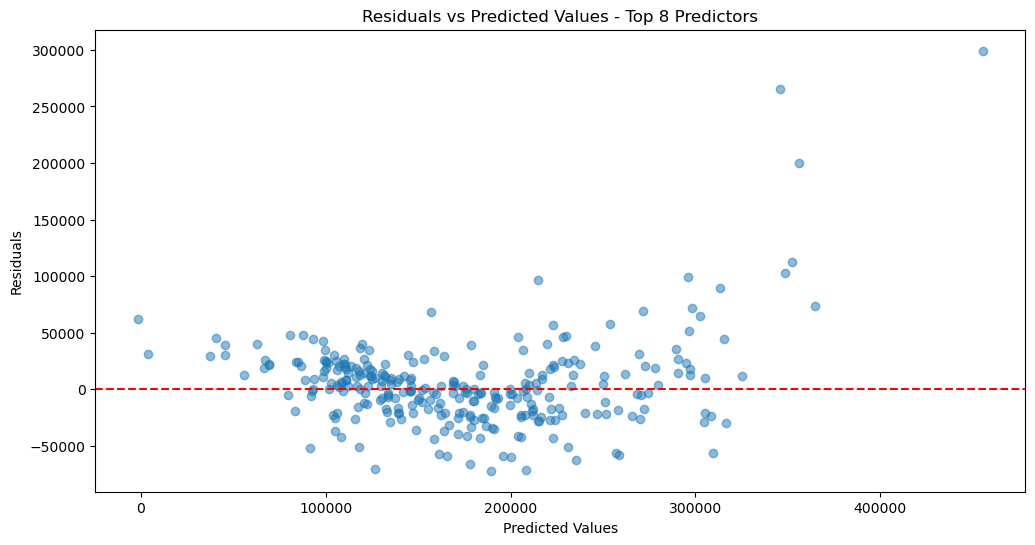

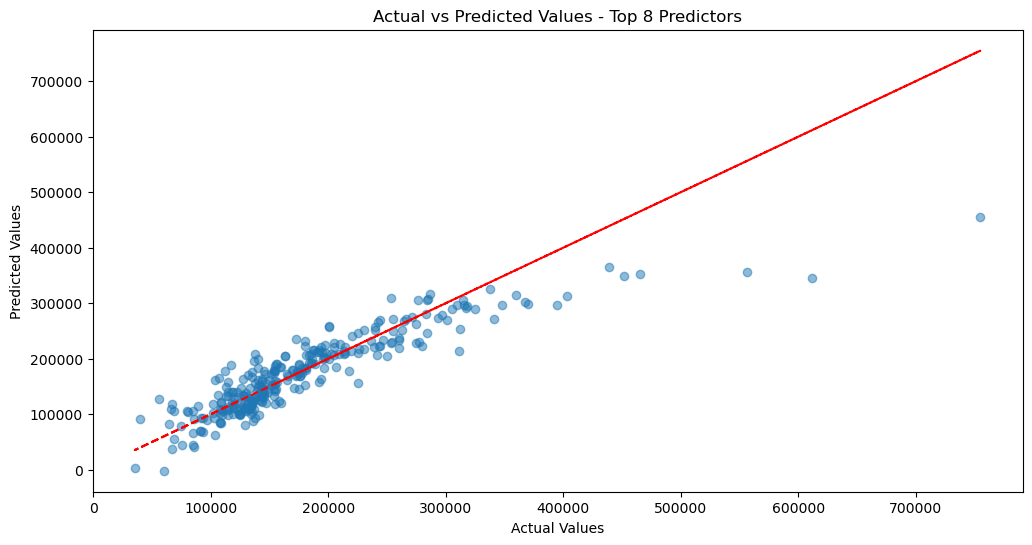

Finished visual evaluation for Top 8 Predictors



In [11]:
# Model 1: Top 15 Predictors
evaluate_model_visuals(model1, X_train1, y_train, X_test1, y_test, "Top 15 Predictors")

# Model 2: Backward Elimination
evaluate_model_visuals(model2, X_train2, y_train, X_test2, y_test, "Backward Elimination")

# Model 3: Top 8 Predictors
evaluate_model_visuals(model3, X_train3, y_train, X_test3, y_test, "Top 8 Predictors")


COnclusion 
Top 15 Predictors performed the best:

Highest R²: 0.811 → Indicates the model explains 81.1% of the variance in house prices.
Lowest MSE: 1.45e+09 → Demonstrates the lowest prediction error.
Lowest AIC: 27865.76 → Reflects the most parsimonious (balanced) model.
VIF-Reduced Predictors model performed poorly:

Lowest R² and highest MSE indicate underfitting due to excessive predictor removal.
Top 8 Predictors model was a close second:

Slightly lower R² and marginally higher AIC compared to the Top 15 Predictors model.
Conclusion:
The Top 15 Correlated Predictors model is the most suitable for predicting house prices. It achieves the best balance between accuracy (R² and MSE) and parsimony (AIC).

Recommendations:
Use the Top 15 Predictors model for practical implementation and further analysis.
Validate the model on unseen data to confirm its robustness.
If simplicity is a priority, consider the Top 8 Predictors model as a trade-off.
This structured approach demonstrates a clear workflow for predictor selection, model evaluation, and identifying the best model in a data science context.